In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"

np.random.seed(10)

random_dim = 100

In [4]:
def load_minst_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [5]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [6]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [7]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [8]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [12]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('Generated_images/gan_generated_at_epoch_%d.png' % epoch)

In [13]:
def train(epochs=1, batch_size=128):
    x_train, y_train, x_test, y_test = load_minst_data()
    batch_count = x_train.shape[0] // batch_size

    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size) 
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 10 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(40, 128)

--------------- Epoch 1 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 19.32it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.53it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.85it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.43it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.09it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.76it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 20.06it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 19.33it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.78it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.26it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 17.54it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:27<00:00, 16.84it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.62it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 19.12it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 19.14it/s]


--------------- Epoch 16 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.52it/s]


--------------- Epoch 17 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 20.37it/s]


--------------- Epoch 18 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 17.83it/s]


--------------- Epoch 19 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.20it/s]


--------------- Epoch 20 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.39it/s]


--------------- Epoch 21 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.77it/s]


--------------- Epoch 22 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 18.94it/s]


--------------- Epoch 23 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.73it/s]


--------------- Epoch 24 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.51it/s]


--------------- Epoch 25 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.74it/s]


--------------- Epoch 26 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.53it/s]


--------------- Epoch 27 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.47it/s]


--------------- Epoch 28 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 19.74it/s]


--------------- Epoch 29 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.49it/s]


--------------- Epoch 30 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.42it/s]


--------------- Epoch 31 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.53it/s]


--------------- Epoch 32 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.56it/s]


--------------- Epoch 33 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.52it/s]


--------------- Epoch 34 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.87it/s]


--------------- Epoch 35 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 19.43it/s]


--------------- Epoch 36 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.69it/s]


--------------- Epoch 37 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 21.07it/s]


--------------- Epoch 38 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.89it/s]


--------------- Epoch 39 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.06it/s]


--------------- Epoch 40 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 19.16it/s]


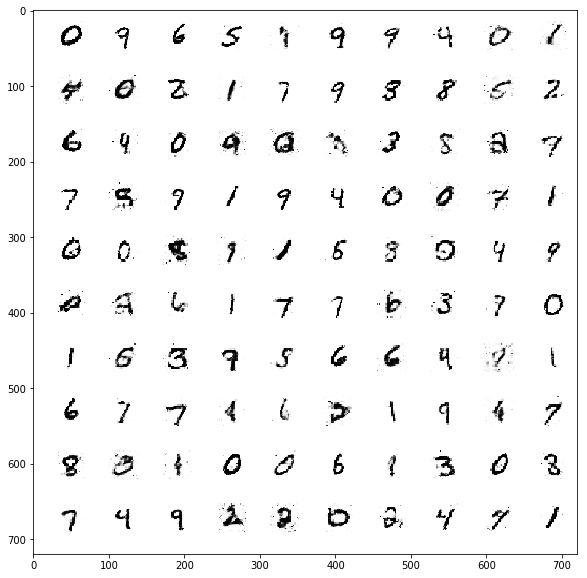

In [32]:
import matplotlib.image as mp
img=mp.imread('Generated_images/gan_generated_at_epoch_40.png')
imgplot = plt.imshow(img)
plt.show()